In [1]:
import warnings

import polars as pl

import faiss
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
SEED = 4001

In [3]:
beats_df = pl.read_parquet("./data/beats.pqt.zst")
beats_df.sample(5)

signal,symbol,is_arrhythmia
list[f64],str,bool
"[-0.076704, -0.076362, … -0.118624]","""N""",false
"[-0.055381, -0.06535, … -0.089925]","""N""",false
"[-0.08268, -0.083659, … -0.038697]","""N""",false
"[-0.104796, -0.053411, … -0.077371]","""N""",false
"[0.004082, -0.011487, … -0.067436]","""N""",false


In [45]:
# Due to the big volume, we will down sample the data to 100k samples, keeping
# 50k normal and 50k anomalous (split evenly for each anomaly)
a_samples = beats_df.filter(pl.col("symbol") == "A").sample(100000, shuffle=True, seed=SEED)
v_samples = beats_df.filter(pl.col("symbol") == "V").sample(100000, shuffle=True, seed=SEED)
n_samples = beats_df.filter(pl.col("symbol") == "N").sample(100000, shuffle=True, seed=SEED)

balanced_111_df = pl.concat([a_samples, v_samples, n_samples]).sample(fraction=1, shuffle=True, seed=SEED)

a_samples = beats_df.filter(pl.col("symbol") == "A").sample(50000, shuffle=True, seed=SEED)
v_samples = beats_df.filter(pl.col("symbol") == "V").sample(50000, shuffle=True, seed=SEED)
n_samples = beats_df.filter(pl.col("symbol") == "N").sample(100000, shuffle=True, seed=SEED)

balanced_112_df = pl.concat([a_samples, v_samples, n_samples]).sample(fraction=1, shuffle=True, seed=SEED)

In [46]:
train, test = train_test_split(beats_df.sample(200000, shuffle=True, seed=SEED), 
                               test_size=0.2, random_state=SEED)

train_X = np.stack(train['signal'].to_numpy())
train_y = train['is_arrhythmia'].to_numpy()

test_X = np.stack(test['signal'].to_numpy())
test_y = test['is_arrhythmia'].to_numpy()

train_bal_111, test_bal_111 = train_test_split(balanced_111_df, test_size=0.2, random_state=SEED)

train_bal_111_X = np.stack(train_bal_111['signal'].to_numpy())
train_bal_111_y = train_bal_111['is_arrhythmia'].to_numpy()

test_bal_111_X = np.stack(test_bal_111['signal'].to_numpy())
test_bal_111_y = test_bal_111['is_arrhythmia'].to_numpy()

train_bal_112, test_bal_112 = train_test_split(balanced_112_df, test_size=0.2, random_state=SEED)

train_bal_112_X = np.stack(train_bal_112['signal'].to_numpy())
train_bal_112_y = train_bal_112['is_arrhythmia'].to_numpy()

test_bal_112_X = np.stack(test_bal_112['signal'].to_numpy())
test_bal_112_y = test_bal_112['is_arrhythmia'].to_numpy()

In [47]:
# Create a test set following the overall beats distribution
test_full = beats_df.sample(50000, shuffle=True, seed=SEED)
test_full_X = np.stack(test_full['signal'].to_numpy())
test_full_y = test_full['is_arrhythmia'].to_numpy()

In [49]:
print(train_bal_111_X.shape)
print(train_bal_111_y.shape)
print(train_bal_112_X.shape)
print(train_bal_112_y.shape)


(240000, 96)
(240000,)
(160000, 96)
(160000,)


In [8]:
res = faiss.StandardGpuResources()

class FaissKNN:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, x, y):
        self.index = faiss.IndexFlatL2(x.shape[1])
        self.index = faiss.index_cpu_to_gpu(res, 0, self.index)

        self.index.add(x.astype(np.float32))
        self.y = y

    def predict(self, x, threshold=0.5):
        _, indices = self.index.search(x.astype(np.float32), k=self.k)
        votes = self.y[indices]

        positive_proportions = np.mean(votes, axis=1)
        
        predictions = (positive_proportions >= threshold).astype(int)
        
        return predictions

In [51]:
knn_bal_111 = FaissKNN(k=100)
knn_bal_111.fit(train_bal_111_X, train_bal_111_y)

knn_bal_112 = FaissKNN(k=100)
knn_bal_112.fit(train_bal_112_X, train_bal_112_y)

knn_unbal = FaissKNN(k=100)
knn_unbal.fit(train_X, train_y)

Balanced Data 1-1-1 KNN
              precision    recall  f1-score   support

       False       0.90      0.87      0.88     19990
        True       0.93      0.95      0.94     40010

    accuracy                           0.92     60000
   macro avg       0.92      0.91      0.91     60000
weighted avg       0.92      0.92      0.92     60000



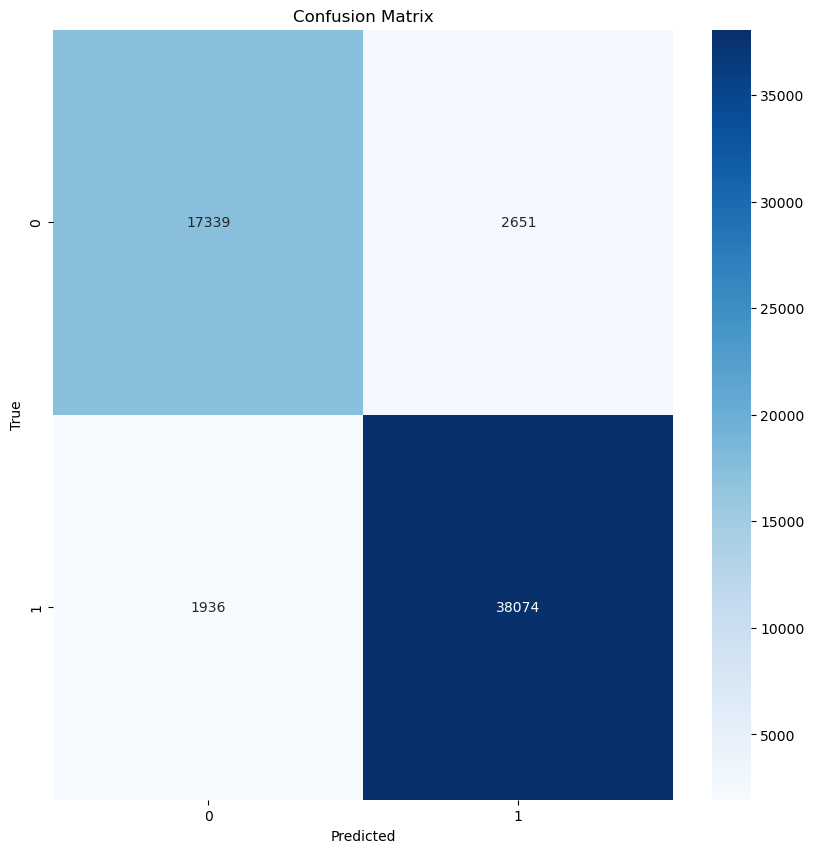

Balanced Data 1-1-2 KNN
              precision    recall  f1-score   support

       False       0.91      0.92      0.91     19890
        True       0.92      0.91      0.91     20110

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000



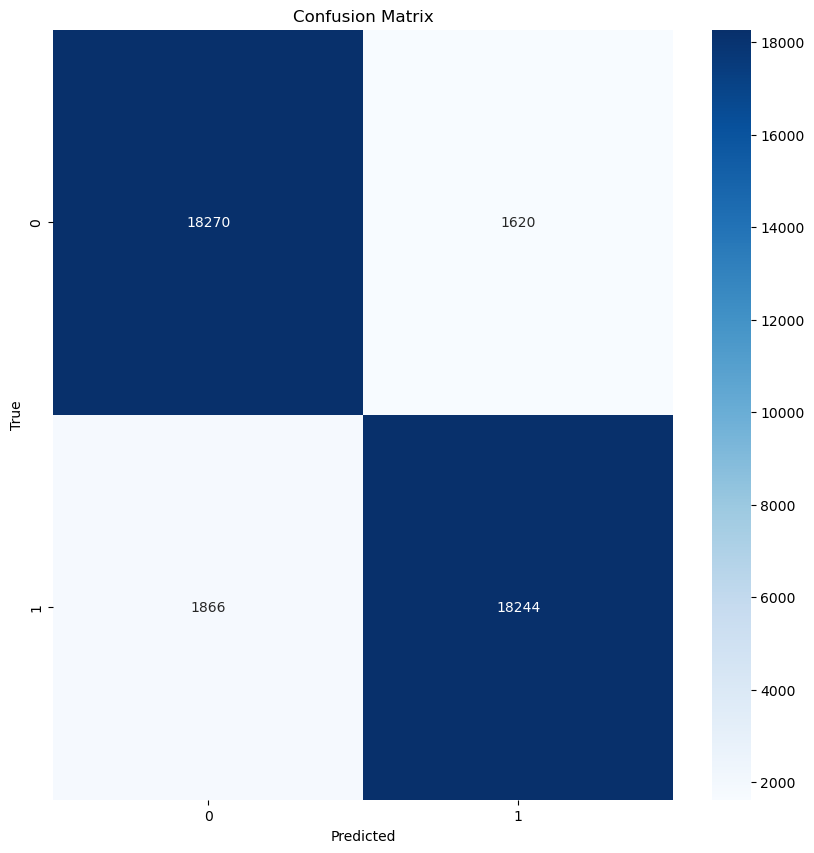

Unbalanced Data KNN
              precision    recall  f1-score   support

       False       0.98      1.00      0.99     38725
        True       0.94      0.27      0.43      1275

    accuracy                           0.98     40000
   macro avg       0.96      0.64      0.71     40000
weighted avg       0.98      0.98      0.97     40000



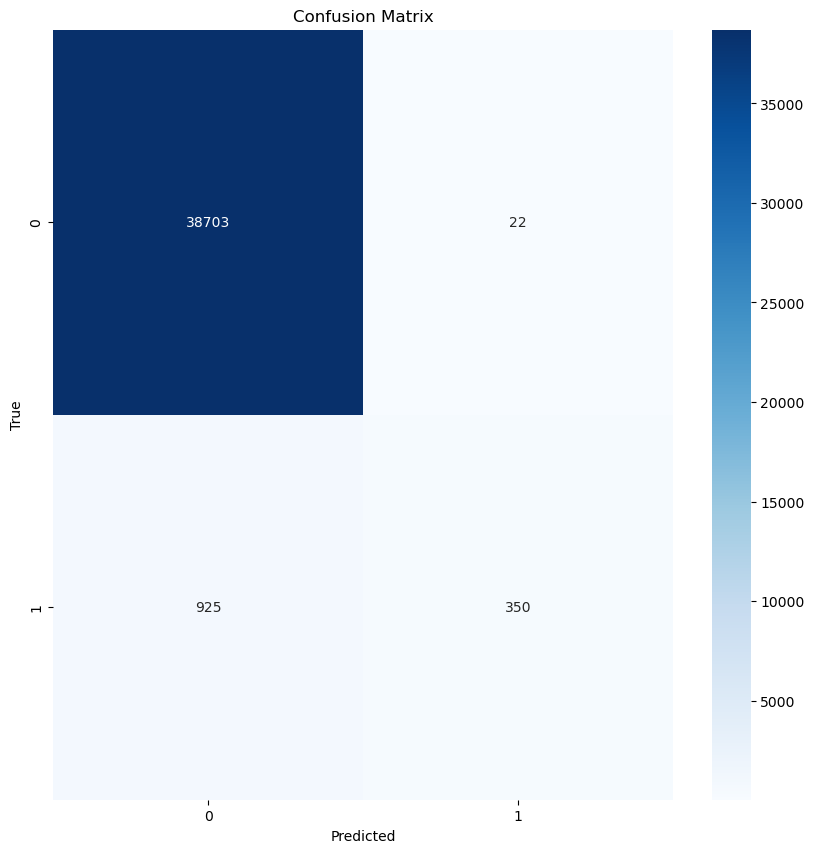

In [52]:
print("Balanced Data 1-1-1 KNN")

preds = knn_bal_111.predict(test_bal_111_X, threshold=0.5)

rep = classification_report(test_bal_111_y, preds)
cm = confusion_matrix(test_bal_111_y, preds)

print(rep)

# Plot confusion matrix with seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Balanced Data 1-1-2 KNN")
preds = knn_bal_112.predict(test_bal_112_X, threshold=0.5)
rep = classification_report(test_bal_112_y, preds)
cm = confusion_matrix(test_bal_112_y, preds)
print(rep)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Unbalanced Data KNN")
preds = knn_unbal.predict(test_X, threshold=0.5)
rep = classification_report(test_y, preds)
cm = confusion_matrix(test_y, preds)
print(rep)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Balanced Data 1-1-1 KNN
              precision    recall  f1-score   support

       False       1.00      0.87      0.93     48403
        True       0.19      0.96      0.32      1597

    accuracy                           0.87     50000
   macro avg       0.60      0.92      0.63     50000
weighted avg       0.97      0.87      0.91     50000



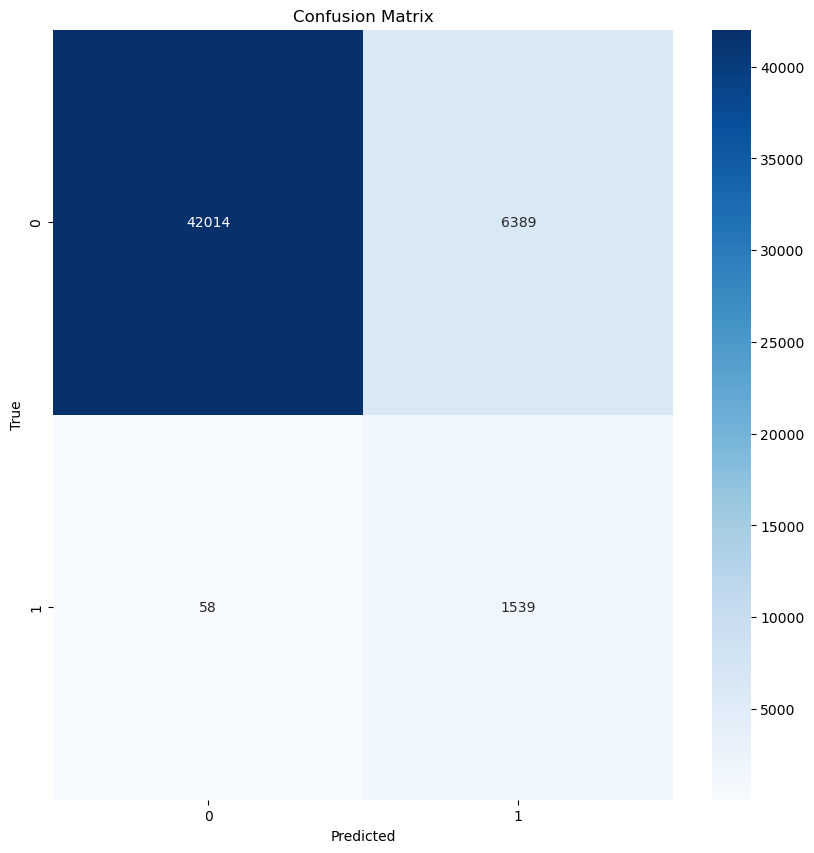

Balanced Data 1-1-2 KNN
              precision    recall  f1-score   support

       False       1.00      0.92      0.96     48403
        True       0.27      0.92      0.42      1597

    accuracy                           0.92     50000
   macro avg       0.63      0.92      0.69     50000
weighted avg       0.97      0.92      0.94     50000



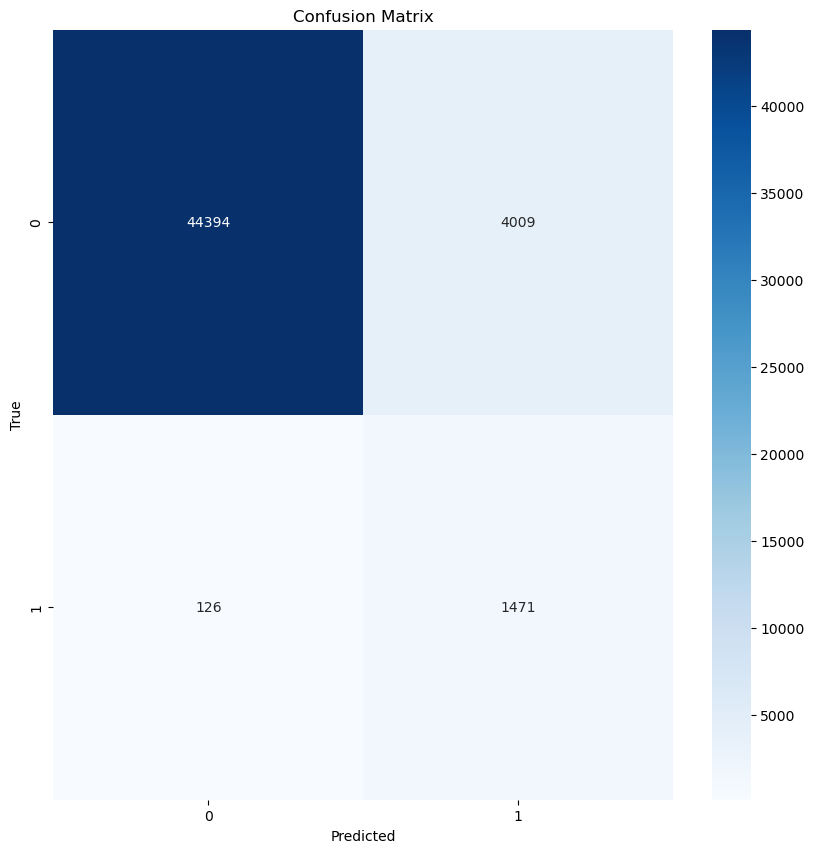

Unbalanced Data KNN
              precision    recall  f1-score   support

       False       0.98      1.00      0.99     48403
        True       0.95      0.30      0.46      1597

    accuracy                           0.98     50000
   macro avg       0.97      0.65      0.72     50000
weighted avg       0.98      0.98      0.97     50000



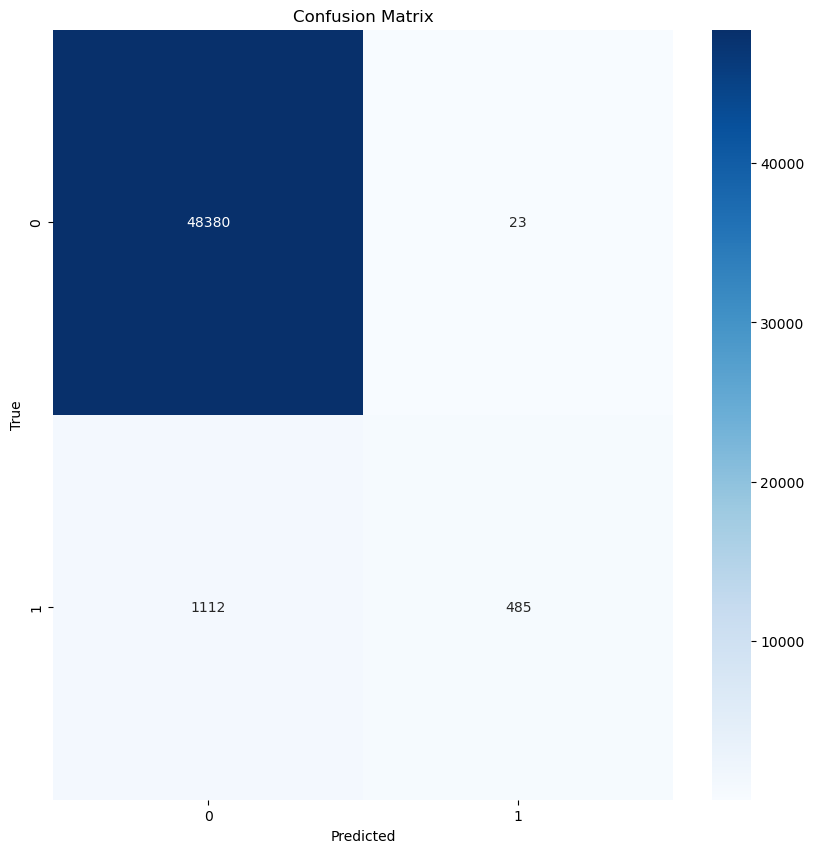

In [53]:
print("Balanced Data 1-1-1 KNN")
preds = knn_bal_111.predict(test_full_X, threshold=0.5)

rep = classification_report(test_full_y, preds)
cm = confusion_matrix(test_full_y, preds)

print(rep)

# Plot confusion matrix with seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Balanced Data 1-1-2 KNN")
preds = knn_bal_112.predict(test_full_X, threshold=0.5)
rep = classification_report(test_full_y, preds)
cm = confusion_matrix(test_full_y, preds)

print(rep)

# Plot confusion matrix with seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f"Unbalanced Data KNN")
preds = knn_unbal.predict(test_full_X, threshold=0.5)
rep = classification_report(test_full_y, preds)
cm = confusion_matrix(test_full_y, preds)   

print(rep)

# Plot confusion matrix with seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()